---
title: "Master Curve & Prony Fitting Example"
author: "Matay@dtu.dk"
date: "2025-01-10"
---

# Master Curve & Prony Series Fitting Demonstration

This notebook demonstrates how to use the `auto_mastercurve.core` module, which provides three classes:

1. **MasterCurve** – Reads and processes raw DMA `.txt` data files (e.g., named `T0.txt`, `T-10.txt`, etc.). It cleans the data, performs shifting to build a single master curve, and can optionally re-shift to a new reference temperature.

2. **MastercurveFitter** – Takes a (shifted) master curve (frequency vs. Storage/Loss data), filters out spurious points, and fits a **Prony series** to represent the viscoelastic behavior.

3. **TemperatureDependency** – Given a set of temperatures and shift factors (in log10 or linear scale), fits a polynomial relationship and can evaluate shift factors at new temperatures.



In [1]:

## Imports & Setup

import sys
import os
import logging
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.gridspec import GridSpec
import seaborn as sns




# If your package is one level up from this notebook directory,
# you can dynamically add its parent path:
sys.path.append(str(Path.cwd().parents[0]))

# Configure logging (optional)
logging.basicConfig(level=logging.INFO)

# Matplotlib styling (optional, matches your preference)
plt.rc('font', family='serif', serif='Times New Roman')
plt.rcParams.update({
    'font.size': 13,    # Font size for axis labels, tick labels, and legends
    'axes.titlesize': 16,
    'axes.labelsize': 16,
    'legend.fontsize': 13,
})

# Now import the classes from your module
from source_code.core import MasterCurve, MastercurveFitter, TemperatureDependency

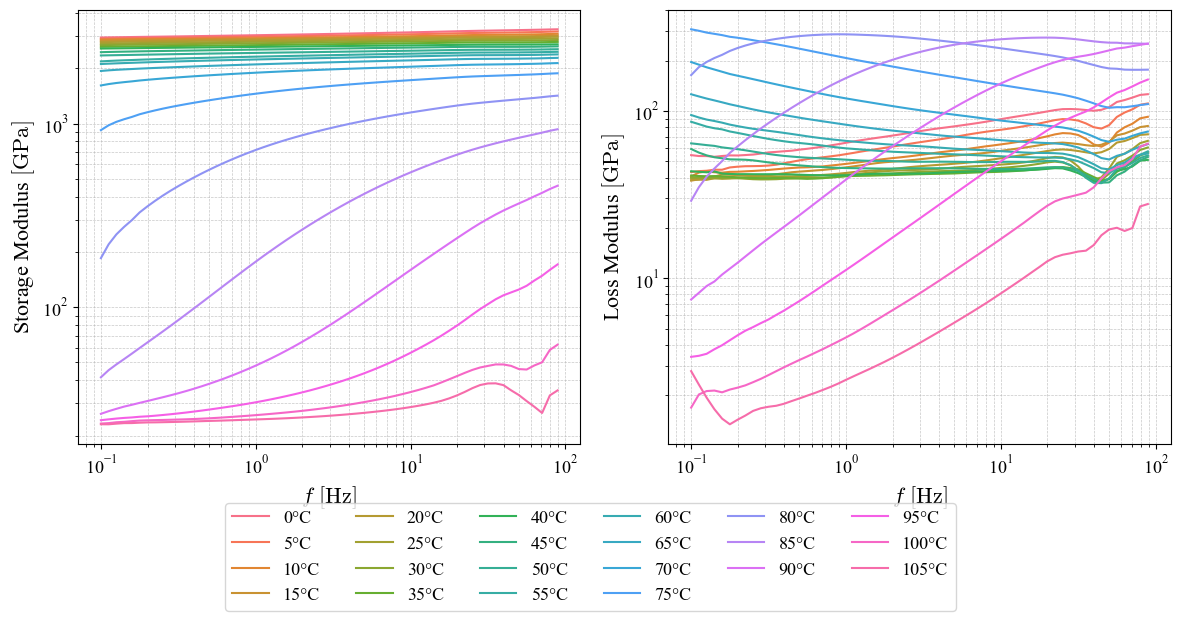

INFO:root:Shift for T_ref=73.0 is -15.567775000000019


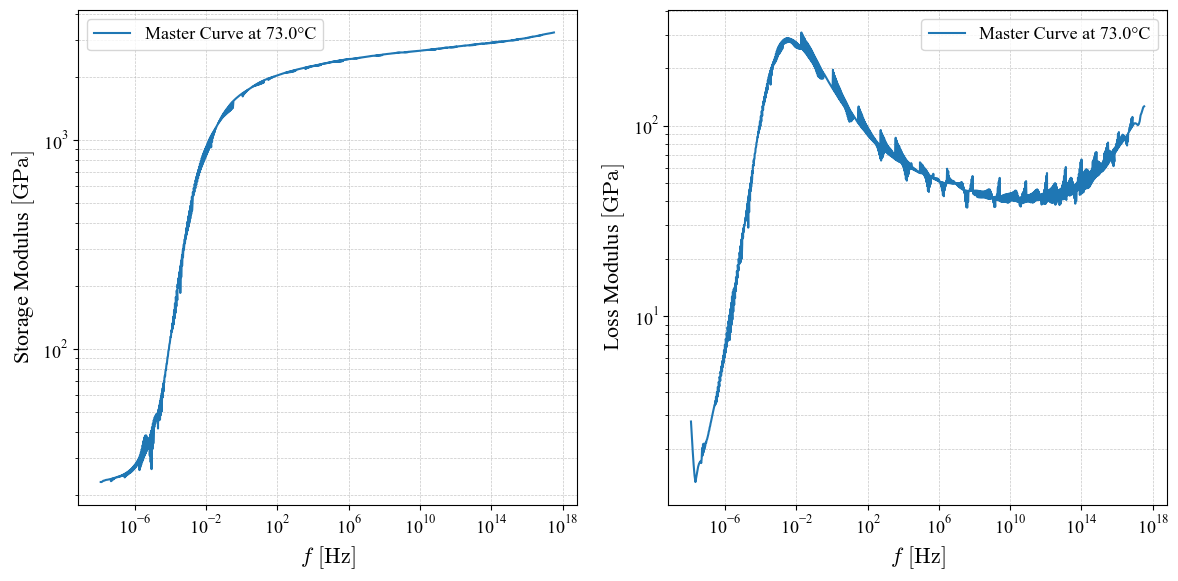

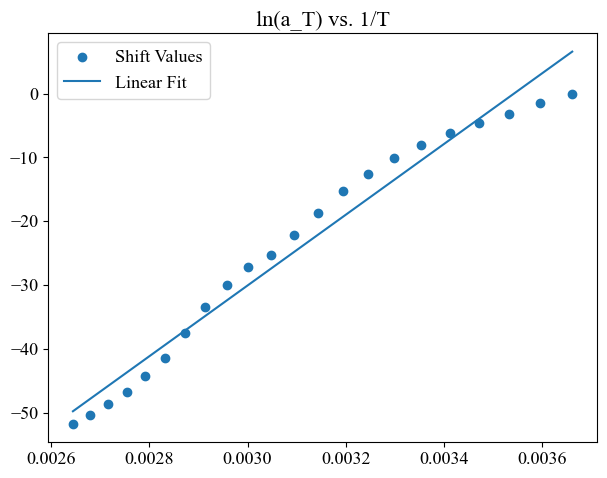

INFO:root:Activation energy (kJ/mol): 460.98
INFO:root:Saved files to results


In [2]:
def run_mastercurve_example(data_dir: Path, ref_temp: float):
    """
    Example usage of the MasterCurve class to process data, adjust shifts,
    and save results to CSV files.
    
    Parameters
    ----------
    data_dir : Path
        Path to the directory containing the data files (T*.txt).
    ref_temp : float
        Reference temperature (in °C) for shift adjustments.
    """
    # 1) Instantiate MasterCurve
    mc = MasterCurve(
        columns=None,
        skiprows=2,
        skipfooter=1,
        delimiter=r'\s+',
        engine='python',
        encoding='iso-8859-1',
        do_plot=True      # Set to True to visualize a quick check of Storage/Loss
    )

    # 2) Build the master curve from the T*.txt files
    final_df, file_names_df = mc.build_master_curve(data_dir)
    if final_df.empty:
        logging.warning("No master curve was built. Check your data_dir or file patterns.")
        return

    # 3) Compute shift values for each temperature & store them in temp_shift_df
    temp_shift_df = pd.DataFrame(columns=['Tr', 'Shift_value'])
    for i, row in file_names_df.iterrows():
        T = row['Temperature']
        jupyter_name = row['Jupyter Name']

        # We look in final_df for the same temperature (Tr==T).
        mask = final_df['Tr'] == T
        if not mask.any():
            continue

        # The first frequency in the final data vs. the first frequency in the raw data
        f_final = final_df.loc[mask, 'f'].reset_index(drop=True)
        original_df = mc.data_dict[jupyter_name][['f', 'Tr']].copy()
        diff_val = f_final[0] - np.log10(original_df['f'].iloc[0])

        # Accumulate shift info
        temp_shift_df = pd.concat([
            temp_shift_df,
            pd.DataFrame({'Tr': [T], 'Shift_value': [diff_val]})
        ], ignore_index=True)

        final_df.loc[mask, 'Shift_value'] = diff_val

    temp_shift_df['Tr'] = temp_shift_df['Tr'].astype(float)
    temp_shift_df['Shift_value'] = temp_shift_df['Shift_value'].astype(float)

    # 4) Optionally re-shift the entire data to a new reference temperature (ref_temp)
    slope, intercept, Ea, final_df, temp_shift_df, final_after_shift = mc.adjust_shift(
        T_ref_new=ref_temp,
        Temp_Shift=temp_shift_df,
        Final=final_df
    )

    # 5) Save results as CSV
    output_dir = Path("results")
    output_dir.mkdir(exist_ok=True)

    final_df.to_csv(output_dir / "final_without_shifting.csv", index=False)
    final_after_shift.to_csv(output_dir / "final_after_shift.csv", index=False)
    temp_shift_df.to_csv(output_dir / "temp_shift.csv", index=False)

    logging.info(f"Saved files to {output_dir}")
    return final_after_shift, temp_shift_df

# Example usage:
data_folder = Path(r"M:\Paper\Conf_paper\DMA-analysis-suite\source_code\Data")
ref_temperature = 73.0
final_after_shift, temp_shift_df = run_mastercurve_example(data_folder, ref_temperature)


# Frequency-Dependent Test Data

The **Prony series** parameters can be calibrated using **frequency-dependent** test data. In this context, many finite element packages (e.g., ABAQUS) use analytical expressions to relate the **Prony series** relaxation functions to the **storage** and **loss** moduli of the material.

Mathematically, starting from a time-domain formulation of viscoelastic behavior and applying the Fourier transform, we obtain the following frequency-domain expressions for the **tensile moduli**:

$$
E'(\omega) = E_0 \left(1 - \sum_{i=1}^{N} e_i \right) + E_0 \sum_{i=1}^{N} \frac{e_i \tau_i^2 \omega^2}{1 + \tau_i^2 \omega^2}
$$

$$
E''(\omega) = E_0 \sum_{i=1}^{N} \frac{e_i \tau_i \omega}{1 + \tau_i^2 \omega^2}
$$

where:

- $E_s(\omega)$ is the **storage modulus** (elastic part).
- $E_{\ell}(\omega)$ is the **loss modulus** (viscous part).
- $\omega$ is the angular frequency $[\mathrm{rad}/\mathrm{s}]$.
- $N$ is the number of Prony terms.
- $E_0$ is the **instantaneous tensile modulus**.
- $e_i^P$ and $\tau_i$ are the **Prony coefficients** and **relaxation times**, respectively.

These expressions are used to determine the Prony series parameters from test data by **minimizing** an error function $\lambda^2$, commonly defined as:

$$
\lambda^2 = \sum_{k=1}^{M} \left( \frac{(E'_k - E'_s(\omega_k))^2}{E_\infty^2} + \frac{(E''_k - E''_l(\omega_k))^2}{E_\infty^2} \right) + \text{Regularization Term}
$$

where:

- $\overline{E_s}$ and $\overline{E_{\ell}}$ are the **experimental** storage and loss moduli at each frequency,
- $E_{\infty}$ is the **long-term tensile modulus**,
- $M$ is the number of experimental data points (frequencies).

Similar expressions exist for the **bulk moduli** $K_s(\omega)$ and $K_{\ell}(\omega)$, and can also be defined for **shear** behavior.

---

## Connection to the `MastercurveFitter` Class

In our code (the `MastercurveFitter` class), we implement this theory by:

1. **Filtering** the master curve data to remove extraneous (e.g., very high modulus) points.
2. Defining **Prony series** functions:
   - `prony_storage(omega, e, tau, E_0)` $\to$ $E_s(\omega)$
   - `prony_loss(omega, e, tau, E_0)` $\to$ $E_{\ell}(\omega)$
3. **Computing** an error function ($\lambda^2$) in the `objective_function`, which includes:
   - Sum of squared differences between experimental $\overline{E_s}, \overline{E_{\ell}}$ and model predictions $E_s, E_{\ell}$,
   - Normalization by $E_\infty^2$,
   - An optional **regularization** term $\lambda_{\mathrm{reg}} \sum e_i^2$.

4. **Optimizing** via `scipy.optimize.minimize` (L-BFGS-B or another method) to find $\{e_i, E_0\}$ that **minimize** this objective.

---

## Simplified Explanation

1. **Prony Series**  
   A method to describe **viscoelastic** materials, where modulus evolves with **time** or **frequency**.

2. **Storage and Loss Moduli**  
   - $E_s(\omega)$: Represents the **elastic** (energy-storing) component.  
   - $E_{\ell}(\omega)$: Represents the **viscous** (energy-dissipating) component.

3. **Frequency Domain**  
   Converting time-domain models (relaxation) into frequency-domain models (storage/loss moduli) clarifies how the material responds at different **frequencies**.

4. **Objective Function**  
   - An error function $\lambda^2$ is used to **fit** or **calibrate** the Prony parameters against experimental data.

---

## Mathematical Explanation

### Prony Series Representation

**Storage modulus**:

$$
E_s(\omega) 
\;=\; 
E_0 \Bigl(\,1 - \sum_{i=1}^N e_i\Bigr)
\;+\; 
E_0 \,\sum_{i=1}^N \frac{\,e_i\,\tau_i^2\,\omega^2\,}{\,1 + \tau_i^2\,\omega^2\,}.
$$

**Loss modulus**:

$$
E_{\ell}(\omega)
\;=\;
E_0 \sum_{i=1}^N \frac{\,e_i\,\tau_i\,\omega\,}{\,1 + \tau_i^2\,\omega^2\,}.
$$

### Objective Function

$$
\lambda^2 
\;=\; 
\sum_{k=1}^M 
\left(\frac{\,E_s^{\mathrm{exp}}(\omega_k) - E_s(\omega_k)\,}{E_\infty}\right)^2 
\;+\;
\sum_{k=1}^M 
\left(\frac{\,E_{\ell}^{\mathrm{exp}}(\omega_k) - E_{\ell}(\omega_k)\,}{E_\infty}\right)^2
\;+\;
\lambda_{\mathrm{reg}} \sum_{i=1}^N e_i^2.
$$

Where $\lambda_{\mathrm{reg}}$ is a **regularization** parameter.

---

## Example Code Snippet

Below is a pseudo-code sample illustrating how these formulas might be used in Python:

```python
import numpy as np

def prony_storage(omega, e, tau, E0):
    return E0 * (1 - np.sum(e)) + E0 * np.sum([
        e[i] * (tau[i]**2 * omega**2) / (1 + tau[i]**2 * omega**2) 
        for i in range(len(e))
    ])

def prony_loss(omega, e, tau, E0):
    return E0 * np.sum([
        e[i] * (tau[i] * omega) / (1 + tau[i]**2 * omega**2) 
        for i in range(len(e))
    ])

def objective_function(params, omega, E_storage_exp, E_loss_exp, E_infty, lambda_reg=0.01):
    # params = [e_1, e_2, ..., e_N, E0]
    e = params[:-1]
    E0 = params[-1]
    
    E_s_model = prony_storage(omega, e, tau, E0)
    E_l_model = prony_loss(omega, e, tau, E0)
    
    # SSE for storage & loss, normalized by E_infty
    residual = np.sum(((E_storage_exp - E_s_model)/E_infty)**2 
                      + ((E_loss_exp - E_l_model)/E_infty)**2)
    
    # Regularization on e
    reg_term = lambda_reg * np.sum(e**2)
    
    return residual + reg_term


Optimization for Prony series succeeded.


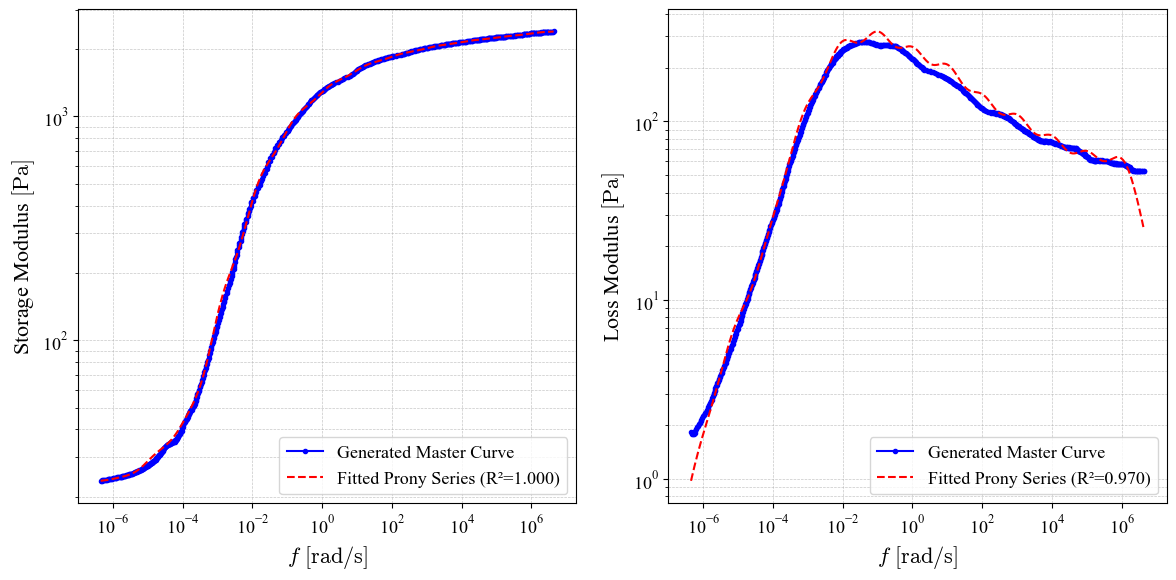

           tau     e      E_0
0        0.000 0.043 2399.754
1        0.000 0.038 2399.754
2        0.000 0.047 2399.754
3        0.001 0.063 2399.754
4        0.010 0.077 2399.754
5        0.100 0.123 2399.754
6        1.000 0.149 2399.754
7       10.000 0.196 2399.754
8      100.000 0.179 2399.754
9     1000.000 0.064 2399.754
10   10000.000 0.007 2399.754
11  100000.000 0.003 2399.754
12 1000000.000 0.001 2399.754


In [3]:
import os

# Example path & file name
results_path = r"C:\Users\matay\Desktop\Python_package\auto_mastercurve\tests\results"
filename = "final_after_shift.csv"
csv_file = os.path.join(results_path, filename)

# 1) Read the CSV file
df = pd.read_csv(csv_file)

# 2) Convert from log10 to linear scale, if needed
df['f']       = (10 ** df['f']) * 2 * np.pi    # frequency in rad/s
df['Storage'] = 10 ** df['Storage']            # storage modulus in MPa
df['Loss']    = 10 ** df['Loss']               # loss modulus in MPa

# 3) Keep relevant columns
df = df[['f', 'Storage', 'Loss']]
df['Complex'] = np.abs(df['Storage'] + 1j * df['Loss'])
df['Phase']   = np.angle(df['Storage'] + 1j * df['Loss'])

# 4) Instantiate MastercurveFitter
fitter = MastercurveFitter(
    df=df,
    checkpoint=2.4e3,    # threshold for trimming out large moduli
    E_infty=2.9e3,       # reference modulus scale
    lambda_reg=0.01,     # regularization
    rolling_window=20,   # smoothing window
)

# 5) Preprocess & filter
fitter.preprocess_and_filter()

# 6) Compute tau array
fitter.compute_tau()

# 7) Fit the Prony series
fitter.fit_prony_series()

# 8) Plot results
fitter.plot_fitted_results()

# 9) Get the Prony parameters (tau, e_i, E_0)
df_prony = fitter.get_prony_parameters()
print(df_prony)


Fitted coefficients (a_3 ... a_0): [ 0.    -0.005 -0.007 14.755]
R^2 = 0.9988029554423731
Polynomial degree: 3
a_3 = 0.000025
a_2 = -0.004530
a_1 = -0.006609
a_0 = 14.754938


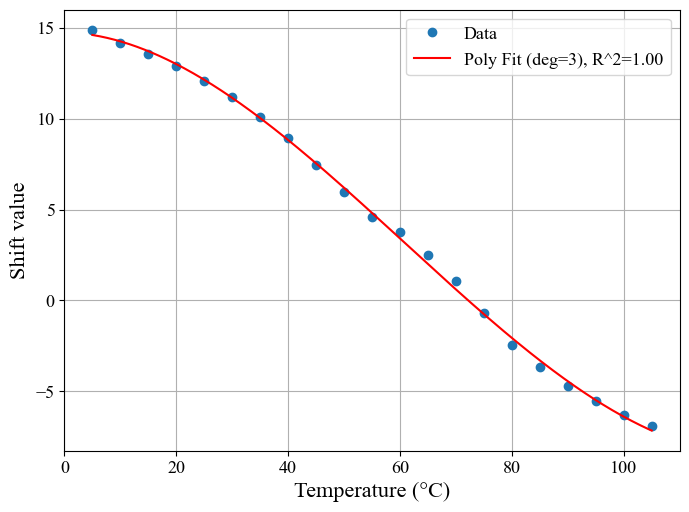


Predicted shift at T=30°C: 11.149


In [4]:
# Let's read our 'temp_shift.csv' that was created in Part 1
path_temp_shift = r"C:\Users\matay\Desktop\Python_package\auto_mastercurve\tests\results"
name_temp_shift = "temp_shift.csv"
df_temp_shift = pd.read_csv(os.path.join(path_temp_shift, name_temp_shift))

# Suppose df columns are: 'Tr' (°C) and 'Shift_value' (log10 shift factor)
T = df_temp_shift['Tr'].values
Y = df_temp_shift['Shift_value'].values

# Instantiate TemperatureDependency
temp_dep = TemperatureDependency(T=T, shift=Y, T_ref=20.0)

# Fit a polynomial of degree=3
coeffs, r2 = temp_dep.fit_polynomial(degree=3)
print("Fitted coefficients (a_3 ... a_0):", coeffs)
print("R^2 =", r2)

# Print coefficients in a user-friendly format
temp_dep.print_coefficients()

# Plot the fit
temp_dep.plot_fit()

# Optionally, retrieve the polynomial model and evaluate at new temperature
poly_model = temp_dep.get_polynomial()
new_temp = 30
predicted_shift = poly_model(new_temp)
print(f"\nPredicted shift at T={new_temp}°C: {predicted_shift:.3f}")


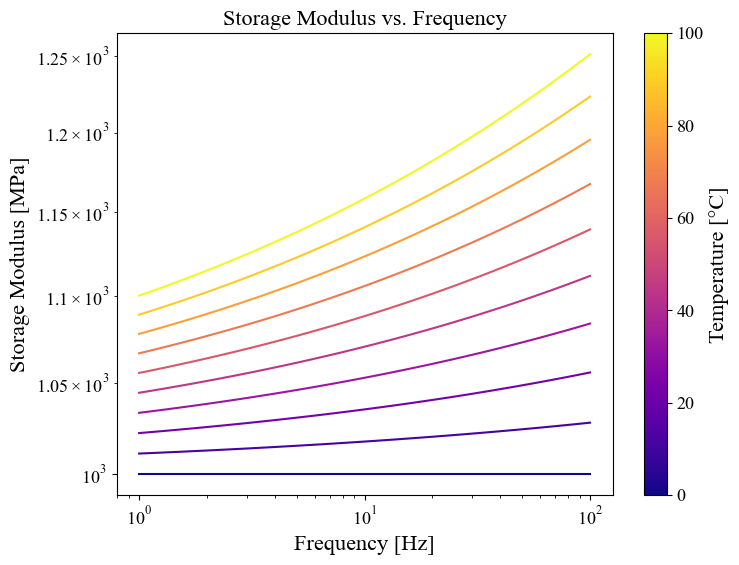

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Example data
frequencies = np.logspace(0, 2, 100)  # Frequency data
temperatures = np.linspace(0, 100, 10)  # Temperature range
colors = cm.plasma(np.linspace(0, 1, len(temperatures)))

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

for temp, color in zip(temperatures, colors):
    storage_modulus = 1e3 + (1e2 * temp / 100) * frequencies**0.2  # Sample data
    ax.plot(frequencies, storage_modulus, color=color)

# Log scale for x and y axes
ax.set_xscale('log')
ax.set_yscale('log')

# Add colorbar for temperature
norm = mcolors.Normalize(vmin=temperatures.min(), vmax=temperatures.max())
sm = plt.cm.ScalarMappable(cmap='plasma', norm=norm)
sm.set_array([])  # Necessary for colorbar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Temperature [°C]')

# Label axes and set title
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Storage Modulus [MPa]')
ax.set_title('Storage Modulus vs. Frequency')

# Display the plot
plt.show()
